<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

### Contents:
- [Problem Statement](#Problem-Statement)
- [Data Collection](#Data-Collection)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

This workbook only contain contents on 'Preprocessing & Modeling', 'Evaluation and Conceptual Understanding' and 'Conclusions and Recommendations'.

In [1]:
#Importing of modules
import numpy as np
import pandas as pd 
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
import re
import string
import shap
import warnings
warnings.filterwarnings('ignore')

# Set max display of columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import nltk
from bs4 import BeautifulSoup    
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator#, STOPWORDS
from PIL import Image
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# Importing datasets
df = pd.read_csv('./data/dfmaster.csv')

In [3]:
df.shape

(2469, 5)

In [4]:
df.dtypes

is_aliens         int64
text             object
score             int64
upvote_ratio    float64
num_comments      int64
dtype: object

In [5]:
# check for NAs
df.isna().sum()

# No NAs so we dont need to dropna

is_aliens       0
text            0
score           0
upvote_ratio    0
num_comments    0
dtype: int64

In [6]:
# Reset index.
df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

,is_aliens,text,score,upvote_ratio,num_comments
0,0,anyone know ive seen,1,1.0,1
1,0,nasa plan nuclear plant moon,1,1.0,0
2,0,think black hole might pocket pocket specifica...,1,1.0,0
3,0,astronomer produced comprehensive image radio ...,1,1.0,0
4,0,considered one sharpest moon image world final...,1,1.0,0


In [8]:
df.columns

Index(['is_aliens', 'text', 'score', 'upvote_ratio', 'num_comments'], dtype='object')

## Preprocessing & Modeling

- Does the student properly split and/or sample the data for validation/training purposes?

### Create Feature Matrix and Target

__The purpose over here is to split the dataset into train, validate and test.__

__That is why we split twice and the proportion distributed is train - 60%, validation  - 20%, test - 20%.  This is to ensure there is no data leakage and to make sure, X_test and y_test remains untouched__

In [9]:
# features = ['text', 'score', 'upvote_ratio', 'num_comments']
# X = df[features]
X = df['text']
y = df['is_aliens']

In [10]:
# Train/Test split
# test size  = 20%
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    test_size= 0.2, 
                                                    stratify=y)

In [11]:
# Splitting the training set again
# This is to ensure there is no data leakage and to make sure, X_test and y_test remains untouched
# val size = 25% of 80% train set = 20%
# train size = 75% of 80% train set = 60%
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state=42,
                                                  test_size=0.25,
                                                  stratify=y_train)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1481,)
(494,)
(494,)


Does the student accurately identify and explain the baseline score?

### __Baseline Score__

The baseline accuracy is the percentage of the aliens class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat.

For every post we select, there is 45% chance that it is under subreddit aliens.

In [13]:
y.value_counts(normalize=True)

0    0.545565
1    0.454435
Name: is_aliens, dtype: float64

- Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: Random Forest and one other model)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?

### __Model Selection__

In this section, I will explore 3 models. They are Naive Bayes, Logistic Regression and Random Forest. I will run each model twice, first time using CountVertorizer and second time using Term Frequency-Inverse Document Frequency (TF-IDF). I will provide a short explaination of each model and evaluate its performance success/downfalls.

1. Naive Bayes

The Naive Bayes classification algorithm is a classificiation modeling techinque which relies on Bayes Theorem. It makes one simplifying assumption that features are independent of one another.
The advantages of Naive Bayes are it is easy to calculate probabilities and returns empirically accurate result.
The disadvantage is the assumption of feature independence is unrealistic, especially in the case of text data. The predicted probabilites can be quite bad.

2. Logistic Regression

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.
Logistic regression uses the logit link to bend our line of best fit. This allows us to predict between 0 and 1 for any value of inputs.

__logit (P(Y=1))=β0+β1X1+β2X2+⋯+βpXp__

- The advantage of logistic regression are the coefficients are interpretable and it shares similar properties to linear regression. 
- The disadvantage is the assumption of linearity between the dependent variable and independent variables. Logistic Regression requires average or no mulitcollinearity between independent variables. 

3. Random Forest

They use a modified tree learning algorithm that selects, at each split in the learning process, a **random subset of the features**. This process is sometimes called the *random subspace method*.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

For a problem with $p$ features, it is typical to use:

- $\sqrt{p}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.

Random forests, a step beyond bagged decision trees, are **very widely used** classifiers and regressors. They are relatively simple to use because they require very few parameters to set and they perform pretty well.

- The advantages are it reduces overfitting in decision trees and helps to improve the accuracy and normalising of data is not required as it uses a rule-based approach. However, despite these advantages, a random forest algorithm also has some drawbacks.

- The disadvantages are it requires much computational power as well as resources as it builds numerous trees to combine their outputs. It also requires much time for training as it combines a lot of decision trees to determine the class. Lastly, due to the ensemble of decision trees, it also suffers interpretability and fails to determine the significance of each variable.


With these 3 models, we will have sufficient info to make an assessment.

### __Naive Bayes with CountVectorizer__

In [14]:
# Start our timer.
%time
t0 = time.time()

pipe_nb_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB())
])
params_nb_cv = {
    'cv__stop_words': [None, 'english'],
    'cv__ngram_range': [(1, 1), (1, 2)],
    'cv__max_df': [.05, .1, .5, .75, .98], 
    'cv__min_df': [2, 4, 6],
    'nb__alpha' : [0.8, 1.0, 1.2],
}

gs_nb_cv = GridSearchCV(pipe_nb_cv, param_grid=params_nb_cv, cv=5, n_jobs=-1)
gs_nb_cv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
Time taken to run the model: 8.78s


In [28]:
# Finding the best parameters 
print('Best params:', gs_nb_cv.best_params_)
print('\n')
print('Best score:', gs_nb_cv.best_score_)

Best params: {'cv__max_df': 0.5, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english', 'nb__alpha': 1.2}


Best score: 0.862910637910638


In [29]:
cvec_nb = CountVectorizer(analyzer = "word",
                       stop_words='english',
                       max_df=0.5,
                       min_df=2,
                       ngram_range=(1,1))

In [30]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec_nb.fit_transform(X_train).todense(),
                          columns = cvec_nb.get_feature_names())

In [31]:
# Transform our validation data with the already-fit CountVectorizer.
X_val_cvec = pd.DataFrame(cvec_nb.transform(X_val).todense(),
                         columns = cvec_nb.get_feature_names())

In [32]:
nb_cv = MultinomialNB(alpha=1.2)
nb_cv.fit(X_train_cvec,y_train)

MultinomialNB(alpha=1.2)

In [33]:
# Get predictions
y_pred_nb_cv = nb_cv.predict(X_val_cvec)

In [34]:
train_score_nb_cv = nb_cv.score(X_train_cvec, y_train)
val_score_nb_cv = nb_cv.score(X_val_cvec, y_val)
print('Model accuracy on train set:', train_score_nb_cv)
print('Model accuracy on val set:', val_score_nb_cv)

Model accuracy on train set: 0.9270762997974341
Model accuracy on val set: 0.8785425101214575


In [35]:
cf_matrix = confusion_matrix(y_val, y_pred_nb_cv)
print(confusion_matrix(y_val, y_pred_nb_cv))
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_nb_cv).ravel()
print(tn, fp, fn, tp)

[[241  28]
 [ 32 193]]


241 28 32 193


In [36]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  87.9 %
Precision:  87.3 %

Sensitivity:  85.8 %
Specificity:  89.6 %


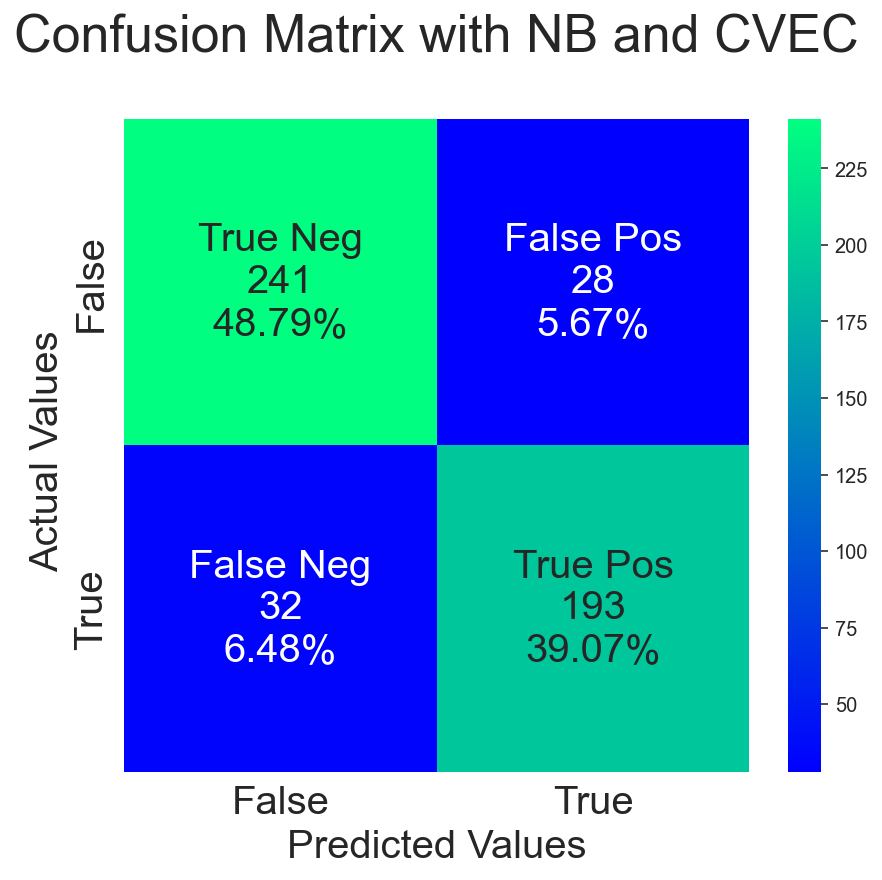

In [37]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with NB and CVEC\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_nb_cvec.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [38]:
print(classification_report(y_val, y_pred_nb_cv))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       269
           1       0.87      0.86      0.87       225

    accuracy                           0.88       494
   macro avg       0.88      0.88      0.88       494
weighted avg       0.88      0.88      0.88       494



### __Observation: Naive Bayes with CountVectorizer__

- The model has a high mean accuracy score (92.7% for training data) and (87.9% for validation data)
- The mean accuracy score for training is quite close to the mean accuracy for validation data.
- The model accuracy is __87.9%.__
- The model also has a higher recall (i.e the percent of positive cases) of 86% for aliens.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 87% for aliens.
- We will use TF-IDF to see if there's any difference in the results of the same Naive Bayes model.
---

### Naive Bayes with Term Frequency-Inverse Document Frequency (TF-IDF)

In [26]:
# Start our timer.
%time
t0 = time.time()

pipe_nb_tv = Pipeline([
    ('tv', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
params_nb_tv = {
    'tv__stop_words': [None, 'english'],
    'tv__ngram_range': [(1, 1), (1, 2)],
    'tv__max_df': [.05, .1, .5, .75, .98], 
    'tv__min_df': [2, 4, 6],
    'nb__alpha' : [0.8, 1.0, 1.2]
}
        
gs_nb_tv = GridSearchCV(pipe_nb_tv, param_grid=params_nb_tv, cv=5, n_jobs=-1)
gs_nb_tv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
Time taken to run the model: 7.66s


In [27]:
# Finding the best parameters 
print('Best params:', gs_nb_tv.best_params_)
print('\n')
print('Best score:', gs_nb_tv.best_score_)

Best params: {'nb__alpha': 1.2, 'tv__max_df': 0.5, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': None}


Best score: 0.8635931385931386


In [39]:
tfidf_nb = TfidfVectorizer(analyzer = "word",
                           stop_words=None,
                           max_df=0.5,
                           min_df=2,
                           ngram_range=(1,2))

In [40]:
# Fit our TF-IDF on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf_nb.fit_transform(X_train).todense(),
                          columns = tfidf_nb.get_feature_names())

In [41]:
# Transform our validation data with the already-fit TF-IDF.
X_val_tfidf = pd.DataFrame(tfidf_nb.transform(X_val).todense(),
                         columns = tfidf_nb.get_feature_names())

In [42]:
nb_tv = MultinomialNB(alpha=1.2)
nb_tv.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=1.2)

In [43]:
# Get predictions
y_pred_nb_tv = nb_tv.predict(X_val_tfidf)

In [44]:
train_score_nb_tv = nb_tv.score(X_train_tfidf, y_train) 
val_score_nb_tv = nb_tv.score(X_val_tfidf, y_val)
print('Model accuracy on train set:', train_score_nb_tv)
print('Model accuracy on val set:', val_score_nb_tv)

Model accuracy on train set: 0.9520594193112761
Model accuracy on val set: 0.8785425101214575


In [45]:
cf_matrix = confusion_matrix(y_val, y_pred_nb_tv)
print(cf_matrix)
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_nb_tv).ravel()
print(tn, fp, fn, tp)

[[246  23]
 [ 37 188]]


246 23 37 188


In [46]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  87.9 %
Precision:  89.1 %

Sensitivity:  83.6 %
Specificity:  91.4 %


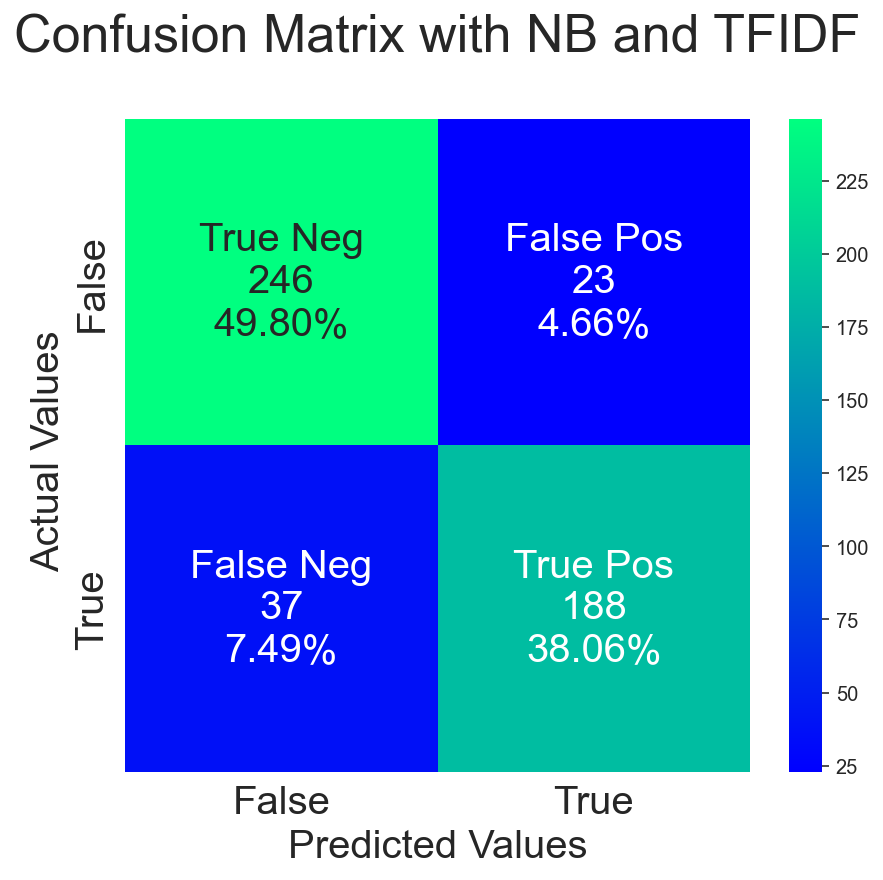

In [47]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with NB and TFIDF\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_nb_tfidf.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [48]:
print(classification_report(y_val, y_pred_nb_tv))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       269
           1       0.89      0.84      0.86       225

    accuracy                           0.88       494
   macro avg       0.88      0.88      0.88       494
weighted avg       0.88      0.88      0.88       494



### __Observation: Naive Bayes with TF-IDF__

- The model has a high mean accuracy score (95.2% for training data) and (87.9% for validation data)
- The mean accuracy score for training is higher than mean accuracy for validation data. The train accuracy increases but the val data remained same. It could be the case of overfitting.
- The model accuracy is __87.9%.__
- The model also has a higher recall (i.e the percent of positive cases) of 84% for aliens.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 86% for aliens.
- Results are similar to the CountVectorizer as TF-IDF
- We will explore other models.
---

### Logistic Regression with CountVectorize

In [51]:
# Start our timer.
%time
t0 = time.time()

pipe_lr_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression())
])
params_lr_cv = {
    'cv__stop_words': [None, 'english'],
    'cv__ngram_range': [(1, 1), (1, 2)],
    'cv__max_df': [.05, .1, .5, .75, .98], 
    'cv__min_df': [2, 4, 6],
    'cv__max_features': [2500, 2750, 3000],
    'lr__C': [1, .05],
    'lr__penalty':['l1','l2']
}

gs_lr_cv = GridSearchCV(pipe_lr_cv, param_grid=params_lr_cv, cv=5, n_jobs=-1)
gs_lr_cv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Time taken to run the model: 41.11s


In [52]:
# Finding the best parameters 
print('Best params:', gs_lr_cv.best_params_)
print('\n')
print('Best score:', gs_lr_cv.best_score_)

Best params: {'cv__max_df': 0.5, 'cv__max_features': 2500, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english', 'lr__C': 1, 'lr__penalty': 'l2'}


Best score: 0.8555032305032306


In [53]:
cvec_lr = CountVectorizer(analyzer = "word",
                          stop_words='english',
                          max_df=0.5,
                          min_df=2,
                          max_features=2500,
                          ngram_range=(1,2))

In [54]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec_lr.fit_transform(X_train).todense(),
                          columns = cvec_lr.get_feature_names())

In [55]:
# Transform our validation data with the already-fit CountVectorizer.
X_val_cvec = pd.DataFrame(cvec_lr.transform(X_val).todense(),
                         columns = cvec_lr.get_feature_names())

In [56]:
lr_cv = LogisticRegression(penalty='l2', C=1)
lr_cv.fit(X_train_cvec,y_train)

LogisticRegression(C=1)

In [57]:
# Get predictions
y_pred_lr_cv = lr_cv.predict(X_val_cvec)

In [58]:
cross_val_score(lr_cv, X_train_cvec, y_train, cv=5).mean()

0.8541496041496041

In [59]:
train_score_lr_cv = lr_cv.score(X_train_cvec, y_train)
val_score_lr_cv = lr_cv.score(X_val_cvec, y_val)
print('Model accuracy on train set:', train_score_lr_cv)
print('Model accuracy on val set:', val_score_lr_cv)

Model accuracy on train set: 0.975016880486158
Model accuracy on val set: 0.868421052631579


In [60]:
cf_matrix = confusion_matrix(y_val, y_pred_lr_cv)
print(confusion_matrix(y_val, y_pred_lr_cv))
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_lr_cv).ravel()
print(tn, fp, fn, tp)

[[246  23]
 [ 42 183]]


246 23 42 183


In [61]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  86.8 %
Precision:  88.8 %

Sensitivity:  81.3 %
Specificity:  91.4 %


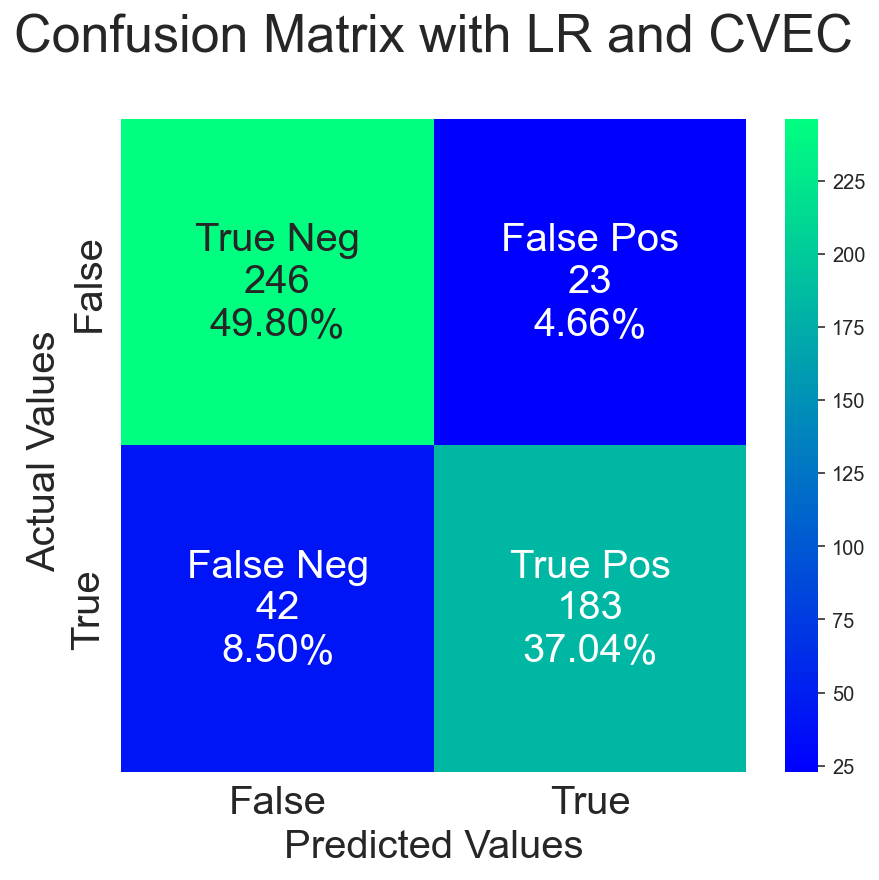

In [62]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with LR and CVEC\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_lr_cvec.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
print(classification_report(y_val, y_pred_lr_cv))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       269
           1       0.89      0.81      0.85       225

    accuracy                           0.87       494
   macro avg       0.87      0.86      0.87       494
weighted avg       0.87      0.87      0.87       494



In [64]:
lr_cv_coef_value = pd.DataFrame(data=lr_cv.coef_.T, index=cvec_lr.get_feature_names())
lr_cv_coef_value.columns = ['coef']
lr_cv_coef_value['exp_coef'] = np.exp(lr_cv_coef_value['coef'])
lr_cv_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
alien,2.884012,17.885889
ufo,2.431913,11.380636
believe,1.308908,3.702130
disclosure,1.280566,3.598676
strange,1.253367,3.502114
grey,1.230122,3.421646
guy,1.211720,3.359259
sighting,1.206290,3.341065
shit,1.079470,2.943118
abducted,1.038653,2.825408


In [65]:
lr_cv_coef_value.sort_values(by='exp_coef').head(10)

,coef,exp_coef
space,-1.792292,0.166578
jwst,-1.567439,0.208579
satellite,-1.497869,0.223606
alien life,-1.287729,0.275897
nebula,-1.271581,0.280388
spacex,-1.271455,0.280423
launch,-1.267515,0.281530
nasa,-1.207246,0.299020
moon,-1.199823,0.301247
star,-1.196635,0.302210


### __Observation: Logistic Regression with CountVectorizer__

- The model has a high mean accuracy score (97.5% for training data) and (86.8% for validation data)
- The mean accuracy score for training is much higher than mean accuracy for validation data. It could be the case of overfitting.
- The model accuracy is __86.8%.__
- The model also has a recall (i.e the percent of positive cases) of 81% for aliens.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 85% for aliens.
- The word 'ufo' increases by 1, the post is about 17.9 times as likely to be a aliens post.
- On the other hand, the list of words such as 'jswt', 'satellite' and 'spacex' and indicate that the post is most likely be a space post instead of aliens post.
- We will explore LR with TF-IDF.
---

### Logistic Regression with Term Frequency-Inverse Document Frequency (TF-IDF)

In [66]:
# Start our timer.
%time
t0 = time.time()

pipe_lr_tv = Pipeline([
    ('tv', TfidfVectorizer()),
    ('lr', LogisticRegression())
])
params_lr_tv = {
    'tv__stop_words': [None, 'english'],
    'tv__ngram_range': [(1, 1), (1, 2)],
    'tv__max_df': [.05, .1, .5, .75, .98], 
    'tv__min_df': [2, 4, 6],
    'tv__max_features': [2500, 2750, 3000],
    'lr__C': [1, .05],
    'lr__penalty':['l1','l2']
}
        
gs_lr_tv = GridSearchCV(pipe_lr_tv, param_grid=params_lr_tv, cv=5, n_jobs=-1)
gs_lr_tv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Time taken to run the model: 37.00s


In [67]:
# Finding the best parameters 
print('Best params:', gs_lr_tv.best_params_)
print('\n')
print('Best score:', gs_lr_tv.best_score_)

Best params: {'lr__C': 1, 'lr__penalty': 'l2', 'tv__max_df': 0.5, 'tv__max_features': 2500, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': 'english'}


Best score: 0.86493538993539


In [68]:
tfidf_lr = TfidfVectorizer(analyzer = "word",
                           stop_words=None,
                           max_df=0.5,
                           min_df=2,
                           max_features=2750,
                           ngram_range=(1,2))

In [69]:
# Fit our TF-IDF on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf_lr.fit_transform(X_train).todense(),
                          columns = tfidf_lr.get_feature_names())

In [70]:
# Transform our validation data with the already-fit TF-IDF.
X_val_tfidf = pd.DataFrame(tfidf_lr.transform(X_val).todense(),
                         columns = tfidf_lr.get_feature_names())

In [71]:
lr_tv = LogisticRegression(penalty='l2', C=1)
lr_tv.fit(X_train_tfidf,y_train)

LogisticRegression(C=1)

In [72]:
# Get predictions
y_pred_lr_tv = lr_tv.predict(X_val_tfidf)

In [73]:
cross_val_score(lr_tv, X_train_tfidf, y_train, cv=5).mean()

0.8595368095368097

In [74]:
train_score_lr_tv = lr_tv.score(X_train_tfidf, y_train)
val_score_lr_tv = lr_tv.score(X_val_tfidf, y_val)
print('Model accuracy on train set:', train_score_lr_tv)
print('Model accuracy on val set:', val_score_lr_tv)

Model accuracy on train set: 0.9567859554355166
Model accuracy on val set: 0.8825910931174089


In [75]:
cf_matrix = confusion_matrix(y_val, y_pred_lr_tv)
print(cf_matrix)
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_lr_tv).ravel()
print(tn, fp, fn, tp)

[[253  16]
 [ 42 183]]


253 16 42 183


In [76]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  88.3 %
Precision:  92.0 %

Sensitivity:  81.3 %
Specificity:  94.1 %


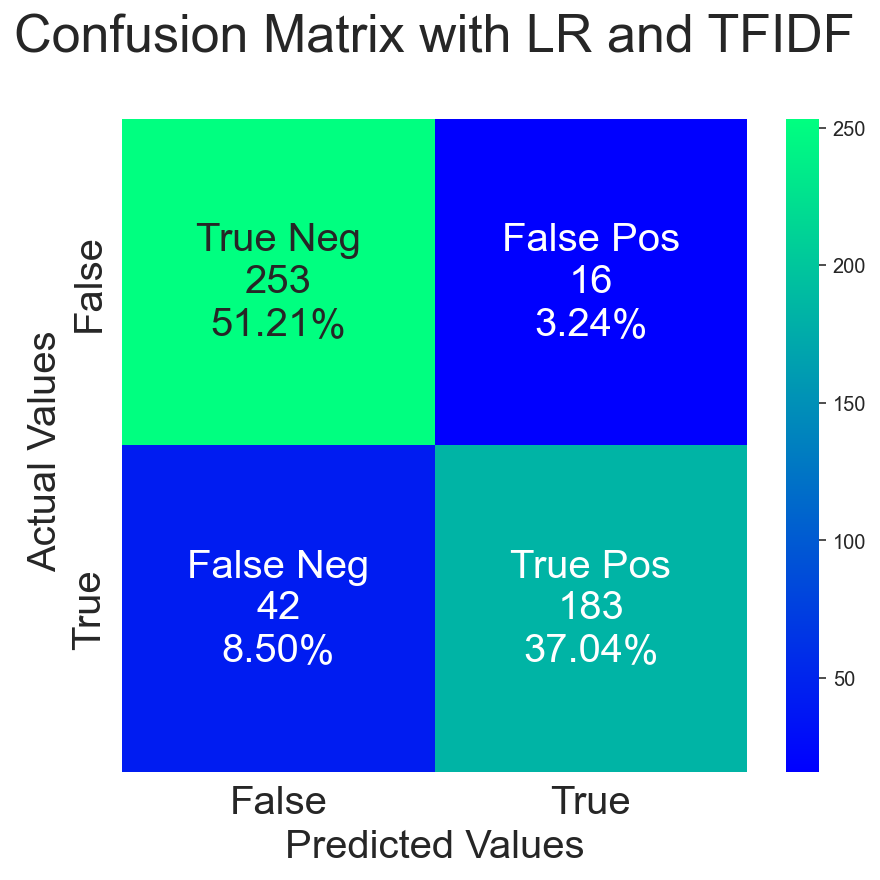

In [77]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with LR and TFIDF\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_lr_tfidf.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [78]:
print(classification_report(y_val, y_pred_lr_tv))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       269
           1       0.92      0.81      0.86       225

    accuracy                           0.88       494
   macro avg       0.89      0.88      0.88       494
weighted avg       0.89      0.88      0.88       494



In [79]:
lr_tv_coef_value = pd.DataFrame(data=lr_tv.coef_.T, index=tfidf_lr.get_feature_names())
lr_tv_coef_value.columns = ['coef']
lr_tv_coef_value['exp_coef'] = np.exp(lr_tv_coef_value['coef'])
lr_tv_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
alien,6.192030,488.837532
ufo,3.737602,41.997159
human,1.759685,5.810605
guy,1.562592,4.771171
think,1.498656,4.475670
believe,1.491460,4.443580
disclosure,1.452820,4.275155
thought,1.438986,4.216419
strange,1.377113,3.963442
grey,1.353125,3.869499


In [80]:
lr_tv_coef_value.sort_values(by='exp_coef').head(10)

,coef,exp_coef
space,-4.072124,0.017041
nasa,-2.160429,0.115276
launch,-2.096450,0.122892
telescope,-2.016292,0.133148
star,-1.772167,0.169964
moon,-1.735028,0.176395
jwst,-1.520067,0.218697
satellite,-1.390930,0.248844
nebula,-1.339986,0.261849
rocket,-1.280957,0.277771


### __Observation: Logistic Regression with TF-IDF__

- The model has a high mean accuracy score (95.7% for training data) and (88.3% for validation data)
- The mean accuracy score for training is higher than mean accuracy for validation data. 
- The model accuracy is __88.3%.__
- The model also has a higher recall (i.e the percent of positive cases) of 92% for aliens.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 81% for aliens.
- The word 'alien' increases by 1, the post is about 488 times as likely to be a aliens post.
- On the other hand, the list of words such as 'nasa', 'launch' and 'telescope' indicate that the post is most likely be a space post instead of aliens post.
- We will explore Random Forest.
---

### Random Forest with CountVectorize

In [81]:
# Start our timer.
%time
t0 = time.time()

pipe_rf_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])
params_rf_cv = {
    'cv__stop_words': [None, 'english'],
    'cv__ngram_range': [(1, 1), (1, 2)],
    'cv__max_df': [.05, .1, .25, .5, .75, .98], 
    'cv__min_df': [1, 2, 4, 6],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
}

gs_rf_cv = GridSearchCV(pipe_rf_cv, param_grid=params_rf_cv, cv=5, n_jobs=-1)
gs_rf_cv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Time taken to run the model: 630.97s


In [82]:
# Finding the best parameters 
print('Best params:', gs_rf_cv.best_params_)
print('\n')
print('Best score:', gs_rf_cv.best_score_)

Best params: {'cv__max_df': 0.98, 'cv__min_df': 1, 'cv__ngram_range': (1, 2), 'cv__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 200}


Best score: 0.8561834561834563


In [83]:
cvec_rf = CountVectorizer(analyzer = "word",
                     stop_words=None,
                     max_df=0.98,
                     min_df=1,
                     ngram_range=(1,2))

In [84]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec_rf.fit_transform(X_train).todense(),
                          columns = cvec_rf.get_feature_names())

In [85]:
# Transform our validation data with the already-fit CountVectorizer.
X_val_cvec = pd.DataFrame(cvec_rf.transform(X_val).todense(),
                         columns = cvec_rf.get_feature_names())

In [86]:
rf_cv = RandomForestClassifier(max_depth=None, n_estimators=200)
rf_cv.fit(X_train_cvec,y_train)

RandomForestClassifier(n_estimators=200)

In [87]:
# Get predictions
y_pred_rf_cv = rf_cv.predict(X_val_cvec)

In [88]:
cross_val_score(rf_cv, X_train_cvec, y_train, cv=5).mean()

0.8588861588861588

In [89]:
train_score_rf_cv = rf_cv.score(X_train_cvec, y_train)
val_score_rf_cv = rf_cv.score(X_val_cvec, y_val)
print('Model accuracy on train set:', train_score_rf_cv)
print('Model accuracy on val set:', val_score_rf_cv)

Model accuracy on train set: 0.9993247805536799
Model accuracy on val set: 0.8785425101214575


In [90]:
cf_matrix = confusion_matrix(y_val, y_pred_rf_cv)
print(confusion_matrix(y_val, y_pred_rf_cv))
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_rf_cv).ravel()
print(tn, fp, fn, tp)

[[250  19]
 [ 41 184]]


250 19 41 184


In [91]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  87.9 %
Precision:  90.6 %

Sensitivity:  81.8 %
Specificity:  92.9 %


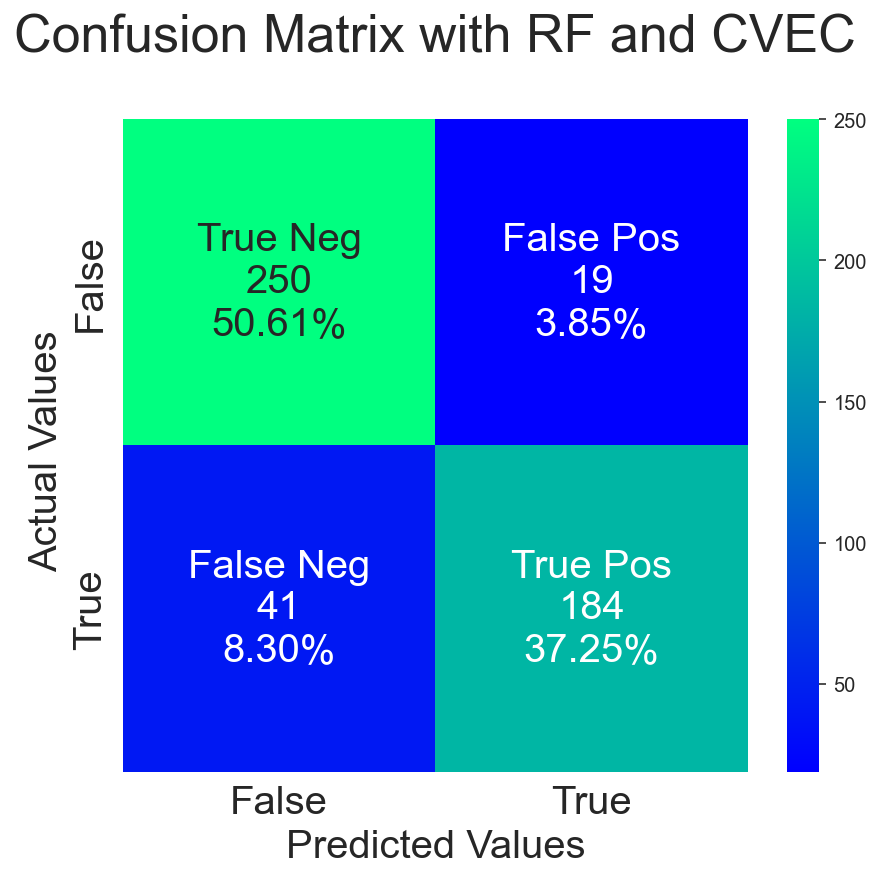

In [92]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with RF and CVEC\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_rf_cvec.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [93]:
print(classification_report(y_val, y_pred_rf_cv))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       269
           1       0.91      0.82      0.86       225

    accuracy                           0.88       494
   macro avg       0.88      0.87      0.88       494
weighted avg       0.88      0.88      0.88       494



### __Observation: Random Forest with CountVectorizer__

- The model has a high mean accuracy score (99.9% for training data) and (87.9% for validation data)
- There seems to be overfitting as the mean accuracy score for training is much higher than mean accuracy for validation data. Accuracy of train to reach 99.9% will be overfitting.
- The model accuracy is __87.9%.__
- The model also has a higher recall (i.e the percent of positive cases) of 82% for aliens.
- It also has a slightly lower precision (i.e the percent of my predictions were correct) score of 82% for aliens as compared to other models.
- We will explore RF with TF-IDF.
---

### Random Forest with Term Frequency-Inverse Document Frequency (TF-IDF)

In [94]:
# Start our timer.
%time
t0 = time.time()

pipe_rf_tv = Pipeline([
    ('tv', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])
params_rf_tv = {
    'tv__stop_words': [None, 'english'],
    'tv__ngram_range': [(1, 1), (1, 2)],
    'tv__max_df': [.05, .1, .5, .75, .98], 
    'tv__min_df': [2, 4, 6],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
}
        
gs_rf_tv = GridSearchCV(pipe_rf_tv, param_grid=params_rf_tv, cv=5, n_jobs=-1)
gs_rf_tv.fit(X_train, y_train)

# Stop our timer and print the result.
print(f'Time taken to run the model: {time.time()-t0:.2f}s')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
Time taken to run the model: 377.53s


In [95]:
# I commented out as it takes a long time to run and the results are shown below.

# Finding the best parameters 
print('Best params:', gs_rf_tv.best_params_)
print('\n')
print('Best score:', gs_rf_tv.best_score_)

Best params: {'rf__max_depth': None, 'rf__n_estimators': 100, 'tv__max_df': 0.75, 'tv__min_df': 2, 'tv__ngram_range': (1, 2), 'tv__stop_words': None}


Best score: 0.8588770588770588


In [96]:
tfidf_rf = TfidfVectorizer(analyzer = "word",
                     stop_words=None,
                     max_df=0.75,
                     min_df=2,
                     ngram_range=(1,2))

In [97]:
# Fit our TF-IDF on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf_rf.fit_transform(X_train).todense(),
                          columns = tfidf_rf.get_feature_names())

In [98]:
# Transform our validation data with the already-fit TF-IDF.
X_val_tfidf = pd.DataFrame(tfidf_rf.transform(X_val).todense(),
                         columns = tfidf_rf.get_feature_names())

In [99]:
rf_tv = RandomForestClassifier(max_depth=None, n_estimators=100)
rf_tv.fit(X_train_tfidf,y_train)

RandomForestClassifier()

In [100]:
# Get predictions
y_pred_rf_tv = rf_tv.predict(X_val_tfidf)

In [101]:
cross_val_score(rf_tv, X_train_tfidf, y_train, cv=5).mean()

0.8467126217126216

In [102]:
train_score_rf_tv = rf_tv.score(X_train_tfidf, y_train)
val_score_rf_tv = rf_tv.score(X_val_tfidf, y_val)
print('Model accuracy on train set:', train_score_rf_tv)
print('Model accuracy on val set:', val_score_rf_tv)

Model accuracy on train set: 0.9952734638757597
Model accuracy on val set: 0.8603238866396761


In [103]:
cf_matrix = confusion_matrix(y_val, y_pred_rf_tv)
print(cf_matrix)
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_rf_tv).ravel()
print(tn, fp, fn, tp)

[[248  21]
 [ 48 177]]


248 21 48 177


In [104]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  86.0 %
Precision:  89.4 %

Sensitivity:  78.7 %
Specificity:  92.2 %


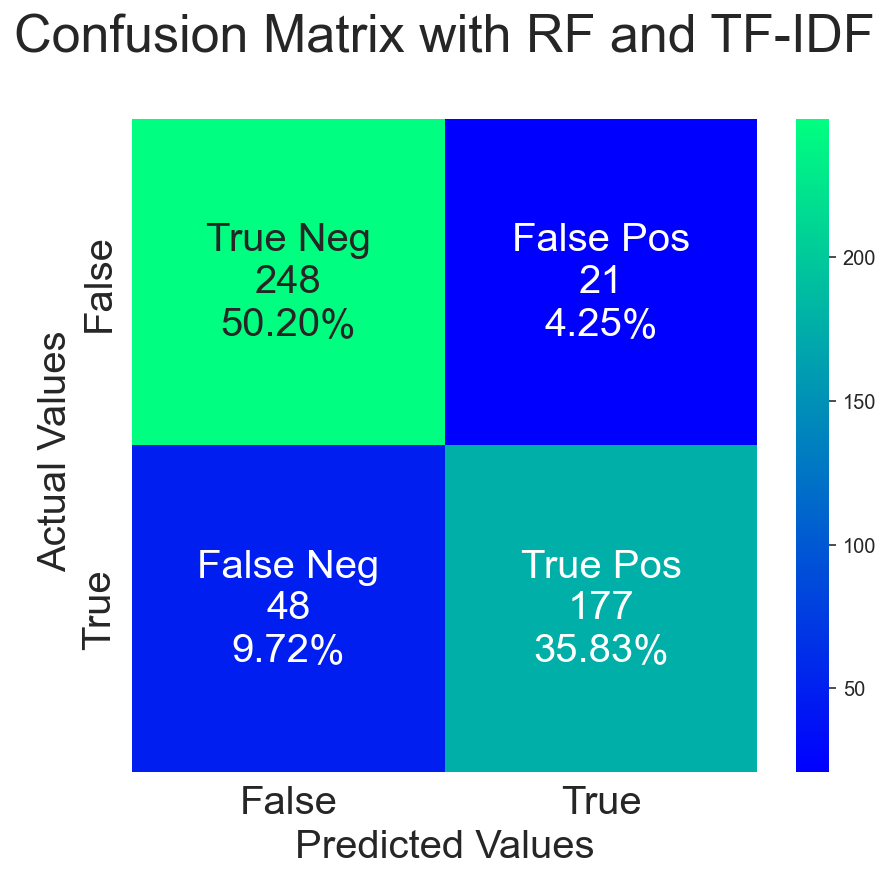

In [105]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix with RF and TF-IDF\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_rf_tfidf.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [106]:
print(classification_report(y_val, y_pred_rf_tv))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       269
           1       0.89      0.79      0.84       225

    accuracy                           0.86       494
   macro avg       0.87      0.85      0.86       494
weighted avg       0.86      0.86      0.86       494



### __Observation: Random Forest with TF-IDF__

- The model has a high mean accuracy score (99.5% for training data) and (86.0% for validation data)
- There seem to be overfitting and the mean accuracy score for training is higher than mean accuracy for validation data. 
- The model accuracy is __86.0%.__
- The model also has a low recall (i.e the percent of positive cases) of 79% for aliens.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 89% for aliens.
---

### Model Comparison

### Best Model selected for test data is Logistic Regression with TF-IDF as it offers the best validation score, the train score are also in a good range and does not show overfitting as compared to Random Forest or too low for Naive Bayes. The difference in the train and validate data for Logistic Regression with TF-IDF is also reasonably under 10.

In [107]:
t = PrettyTable(['Model', 'Train', 'Val', 'Diff', 'Precision', 'F1'])
t.add_row(['Naive Bayes with CountVectorize', '92.7%', '87.9%', '-4.8', '87.3%', '88%'])
t.add_row(['Naive Bayes with TF-IDF', '95.2%', '87.9%', '-7.3', '89.1%', '88%'])
t.add_row(['Logistic Regression with CountVectorize', '97.5%', '86.8%', '-10.7', '88.8%', '87%'])
t.add_row(['Logistic Regression with TF-IDF', '95.7%', '88.3%', '-7.4', '92%', '88%'])
t.add_row(['RandomForestClassifier with CountVectorize', '99.9%', '87.9%', '-12.0', '90.6%', '88%'])
t.add_row(['RandomForestClassifier with TF-IDF', '99.5%', '86.0%', '-13.5', '89.4%', '86%'])
print(t)

+--------------------------------------------+-------+-------+-------+-----------+-----+
|                   Model                    | Train |  Val  |  Diff | Precision |  F1 |
+--------------------------------------------+-------+-------+-------+-----------+-----+
|      Naive Bayes with CountVectorize       | 92.7% | 87.9% |  -4.8 |   87.3%   | 88% |
|          Naive Bayes with TF-IDF           | 95.2% | 87.9% |  -7.3 |   89.1%   | 88% |
|  Logistic Regression with CountVectorize   | 97.5% | 86.8% | -10.7 |   88.8%   | 87% |
|      Logistic Regression with TF-IDF       | 95.7% | 88.3% |  -7.4 |    92%    | 88% |
| RandomForestClassifier with CountVectorize | 99.9% | 87.9% | -12.0 |   90.6%   | 88% |
|     RandomForestClassifier with TF-IDF     | 99.5% | 86.0% | -13.5 |   89.4%   | 86% |
+--------------------------------------------+-------+-------+-------+-----------+-----+


### ROC Curve and with Logistic Regression with TF-IDF selected

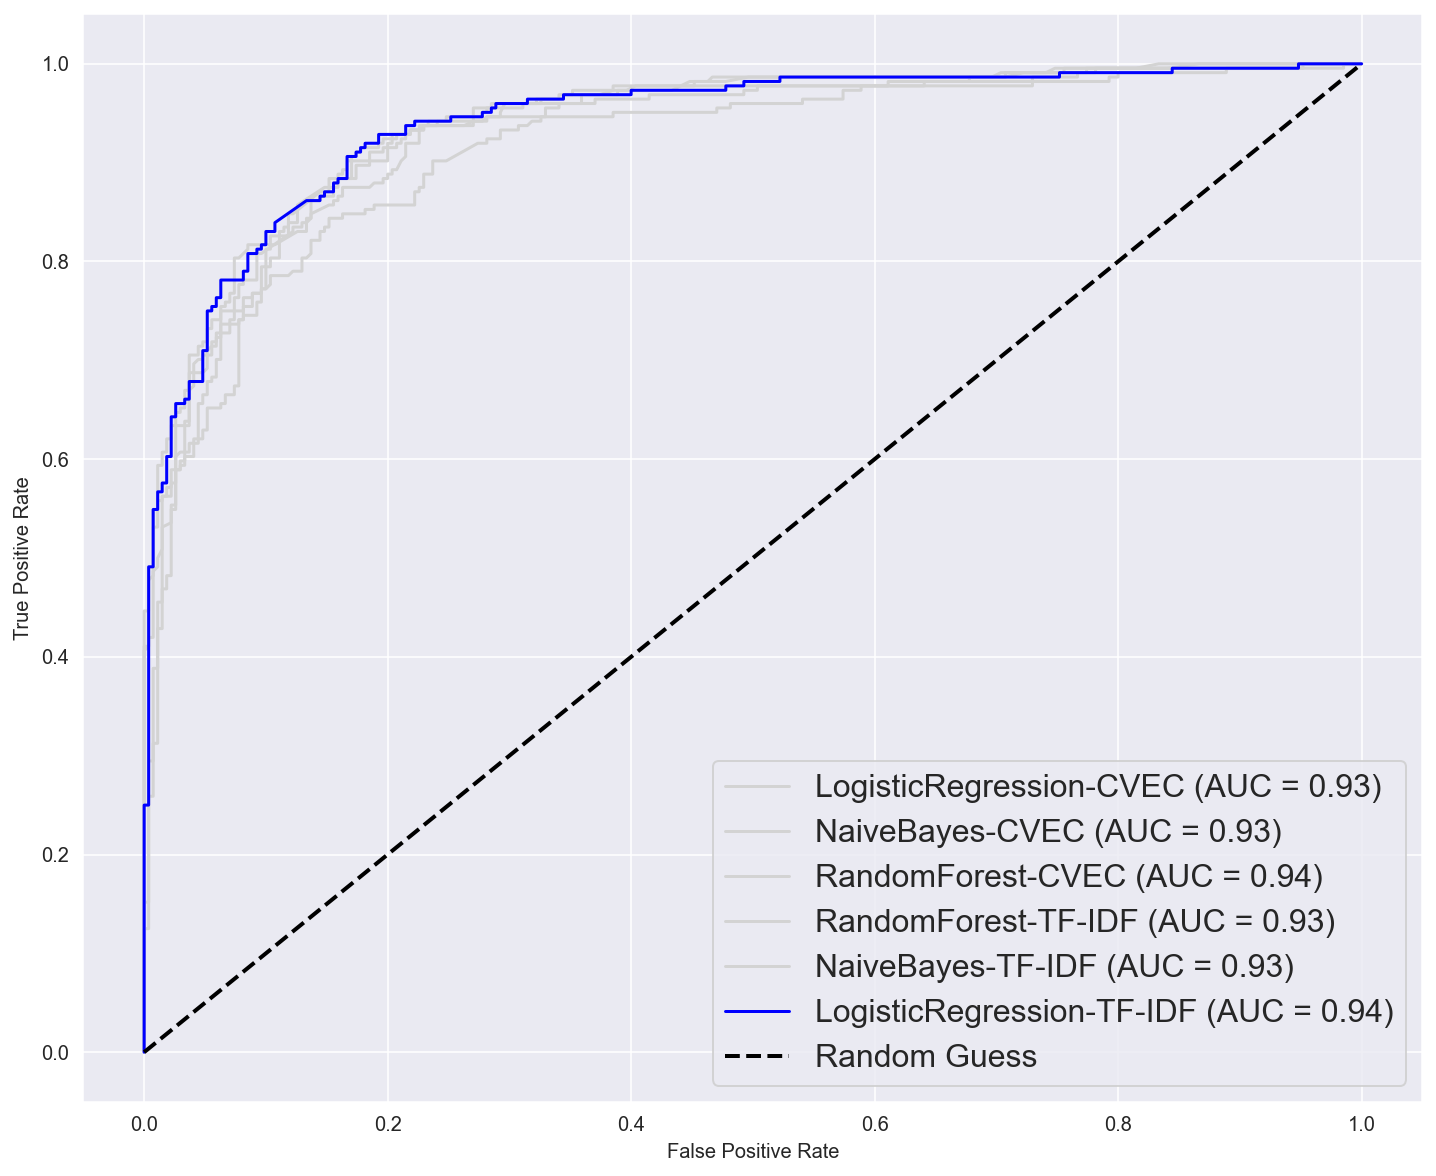

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(gs_lr_cv, X_test, y_test, ax=ax, name='LogisticRegression-CVEC', color='lightgrey')
plot_roc_curve(gs_nb_cv, X_test, y_test, ax=ax, name='NaiveBayes-CVEC', color='lightgrey')
plot_roc_curve(gs_rf_cv, X_test, y_test, ax=ax, name='RandomForest-CVEC', color='lightgrey')
plot_roc_curve(gs_rf_tv, X_test, y_test, ax=ax, name='RandomForest-TF-IDF', color='lightgrey')
plot_roc_curve(gs_nb_tv, X_test, y_test, ax=ax, name='NaiveBayes-TF-IDF', color='lightgrey')
plot_roc_curve(gs_lr_tv, X_test, y_test, ax=ax, name='LogisticRegression-TF-IDF', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend(fontsize=16);
plt.savefig('./images/roc_curve.png')

### Observation

__The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. AUC is the area under the ROC curve.__

__When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.__

__When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.__

__In the ROC curve graph, LogisticRegression TF-IDF/CVEC and Random Forest TF-IDF showed the highest percentage of 0.94 although the rest of the models are also very close second at 0.93. This showed that all the models have consistent results.__

## __Best scoring model - Logistic Regression with TF-IDF- for the Test set__

### __Analysis__
__Logistic Regression with TF-IDF was chosen as its validation score has the best accuracy of 88.3%. The diff between train and set is also very close among all the models and it showed the consistency.__

## Selected Model: Logistic Regression with Term Frequency-Inverse Document Frequency (TF-IDF)

In [109]:
tfidf_lr = TfidfVectorizer(analyzer = "word",
                           stop_words=None,
                           max_df=0.5,
                           min_df=2,
                           max_features=2750,
                           ngram_range=(1,2))

In [110]:
tfidf_lr

TfidfVectorizer(max_df=0.5, max_features=2750, min_df=2, ngram_range=(1, 2))

In [111]:
# Fit our TF-IDF on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf_lr.fit_transform(X_train).todense(),
                          columns = tfidf_lr.get_feature_names())

In [112]:
# Transform our testing data with the already-fit TF-IDF.
X_test_tfidf = pd.DataFrame(tfidf_lr.transform(X_test).todense(),
                         columns = tfidf_lr.get_feature_names())

In [113]:
lr_tv = LogisticRegression(penalty='l2', C=1)
lr_tv.fit(X_train_tfidf,y_train)

LogisticRegression(C=1)

In [114]:
# Get predictions
y_pred_lr_tv_test = lr_tv.predict(X_test_tfidf)

In [116]:
cross_val_score(lr_tv, X_train_tfidf, y_train, cv=5).mean()

0.8595368095368097

In [117]:
train_score_lr_tv = lr_tv.score(X_train_tfidf, y_train)
test_score_lr_tv = lr_tv.score(X_test_tfidf, y_test)
print('Model accuracy on train set:', train_score_lr_tv)
print('Model accuracy on val set:', val_score_lr_tv)
print('Model accuracy on test set:', test_score_lr_tv)

Model accuracy on train set: 0.9567859554355166
Model accuracy on val set: 0.8825910931174089
Model accuracy on test set: 0.8623481781376519


In [118]:
cf_matrix = confusion_matrix(y_test, y_pred_lr_tv_test)
print(cf_matrix)
print('\n')

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr_tv_test).ravel()
print(tn, fp, fn, tp)

[[256  14]
 [ 54 170]]


256 14 54 170


In [119]:
print('Accuracy: ',(round((tp+tn)*100/(tp+fp+tn+fn),1)), '%')
print('Precision: ',(round((tp)*100/(tp+fp),1)), '%\n')
print('Sensitivity: ',(round((tp)*100/(tp+fn),1)), '%')  
print('Specificity: ',(round((tn)*100/(tn+fp),1)), '%')  

Accuracy:  86.2 %
Precision:  92.4 %

Sensitivity:  75.9 %
Specificity:  94.8 %


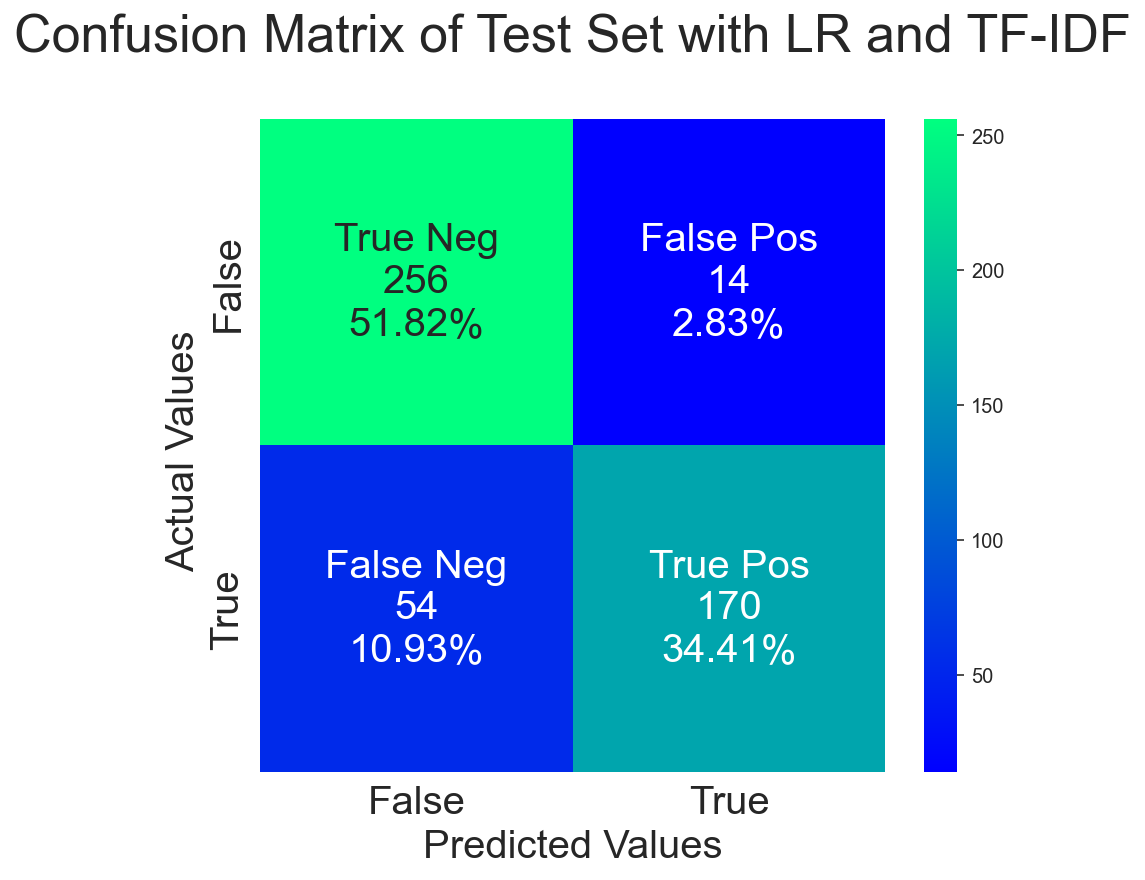

In [120]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (7,6))

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='winter', annot_kws={"size": 20}) #Blues

ax.set_title('Confusion Matrix of Test Set with LR and TF-IDF\n', fontsize=26);
ax.set_xlabel('Predicted Values', fontsize=20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], fontsize=20)
ax.yaxis.set_ticklabels(['False','True'], fontsize=20)

plt.savefig('./images/confusion_matrix_test_lr_tfidf.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [121]:
print(classification_report(y_test, y_pred_lr_tv_test))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       270
           1       0.92      0.76      0.83       224

    accuracy                           0.86       494
   macro avg       0.87      0.85      0.86       494
weighted avg       0.87      0.86      0.86       494



In [122]:
t = PrettyTable(['Model', 'Train', 'Val', 'Test', 'Precision', 'F1'])
t.add_row(['Logistic Regression with TF-IDF', '95.7%', '88.3%', '86.2%', '92.4%', '86%'])
print(t)

+---------------------------------+-------+-------+-------+-----------+-----+
|              Model              | Train |  Val  |  Test | Precision |  F1 |
+---------------------------------+-------+-------+-------+-----------+-----+
| Logistic Regression with TF-IDF | 95.7% | 88.3% | 86.2% |   92.4%   | 86% |
+---------------------------------+-------+-------+-------+-----------+-----+


### Analyzing the coefficient of the words to the dataframe for both subreddits, Space and Aliens

In [123]:
lr_tv_coef_value = pd.DataFrame(data=lr_tv.coef_.T, index=tfidf_lr.get_feature_names())
lr_tv_coef_value.columns = ['coef']
lr_tv_coef_value['exp_coef'] = np.exp(lr_tv_coef_value['coef'])
lr_tv_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
alien,6.192030,488.837532
ufo,3.737602,41.997159
human,1.759685,5.810605
guy,1.562592,4.771171
think,1.498656,4.475670
believe,1.491460,4.443580
disclosure,1.452820,4.275155
thought,1.438986,4.216419
strange,1.377113,3.963442
grey,1.353125,3.869499


In [124]:
lr_tv_coef_value.sort_values(by='exp_coef').head(10)

,coef,exp_coef
space,-4.072124,0.017041
nasa,-2.160429,0.115276
launch,-2.096450,0.122892
telescope,-2.016292,0.133148
star,-1.772167,0.169964
moon,-1.735028,0.176395
jwst,-1.520067,0.218697
satellite,-1.390930,0.248844
nebula,-1.339986,0.261849
rocket,-1.280957,0.277771


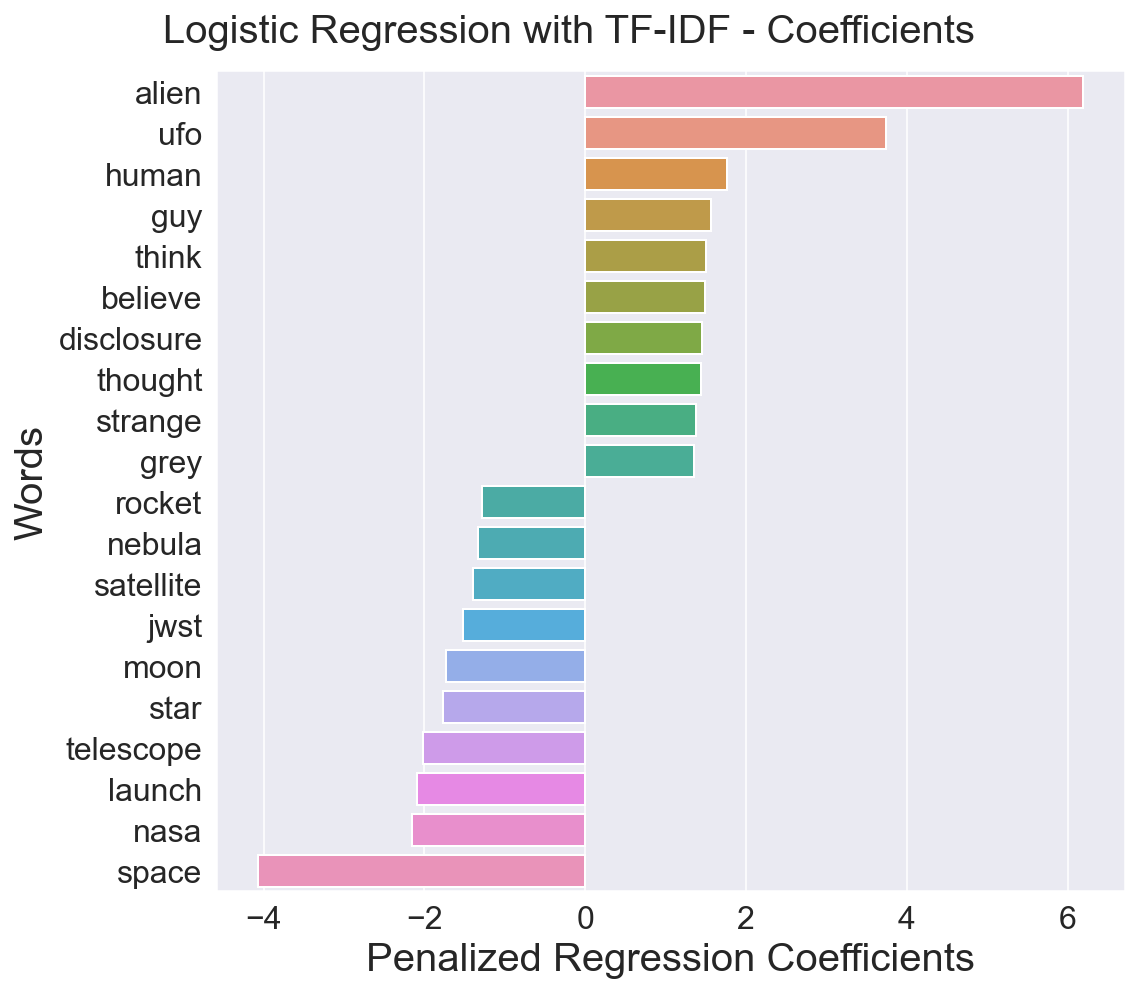

In [125]:
# Create list of logistic regression coefficients 
lr_tv_coef_value = np.array(lr_tv.coef_).tolist()
lr_tv_coef_value = lr_tv_coef_value[0]

# create dataframe from lasso coef
lr_tv_coef_value = pd.DataFrame(np.round_(lr_tv_coef_value, decimals=3), 
tfidf_lr.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_tv_coef_value = lr_tv_coef_value.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_lr_tv_head = lr_tv_coef_value.head(10)
df_lr_tv_tail = lr_tv_coef_value.tail(10)

# merge back together
df_lr_tv_merged = pd.concat([df_lr_tv_head, df_lr_tv_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 7)
fig.suptitle('Logistic Regression with TF-IDF - Coefficients', size=20)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_lr_tv_merged.index, 
data=df_lr_tv_merged)
ax.set_xlabel('Penalized Regression Coefficients', fontsize=20)
ax.set_ylabel('Words', fontsize=20);

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout(pad=1, w_pad=0, h_pad=0);

# save image
plt.savefig('./images/coefficient_lr_tfidf.png')

### Checking on the top 25 words of the dataframe and its frequency to each subreddit, Space and Aliens

Many of the words appeared in both the subreddits and that is why some postings are classified incorrectly. Words like planet, earth and life are all related to both subreddits.

---

In [126]:
cv_simple = CountVectorizer(stop_words='english')
X_train_cv_simple = cv_simple.fit_transform(X_train)

cv_simple_train = pd.DataFrame(X_train_cv_simple.todense(), columns=cv_simple.get_feature_names())

In [127]:
# Create a data frame of the most common words 

n_words = 25
words = list(cv_simple_train.sum().sort_values(ascending=False)[:n_words].index)
cv_simple_train['is_space'] = y_train.values
cv_train_small = cv_simple_train.groupby('is_space').sum()[words]
cv_train_small.head()

,alien,space,like,ufo,telescope,know,planet,earth,launch,nasa,human,life,think,time,moon,year,video,new,amp,webb,light,question,star,people,thought
is_space,,,,,,,,,,,,,,,,,,,,,,,,,
0,14,272,54,4,120,44,69,72,96,88,9,33,18,48,64,51,26,55,36,74,38,34,57,15,12
1,345,26,88,124,5,74,44,40,2,6,85,57,70,39,21,32,54,22,41,2,33,35,8,49,50


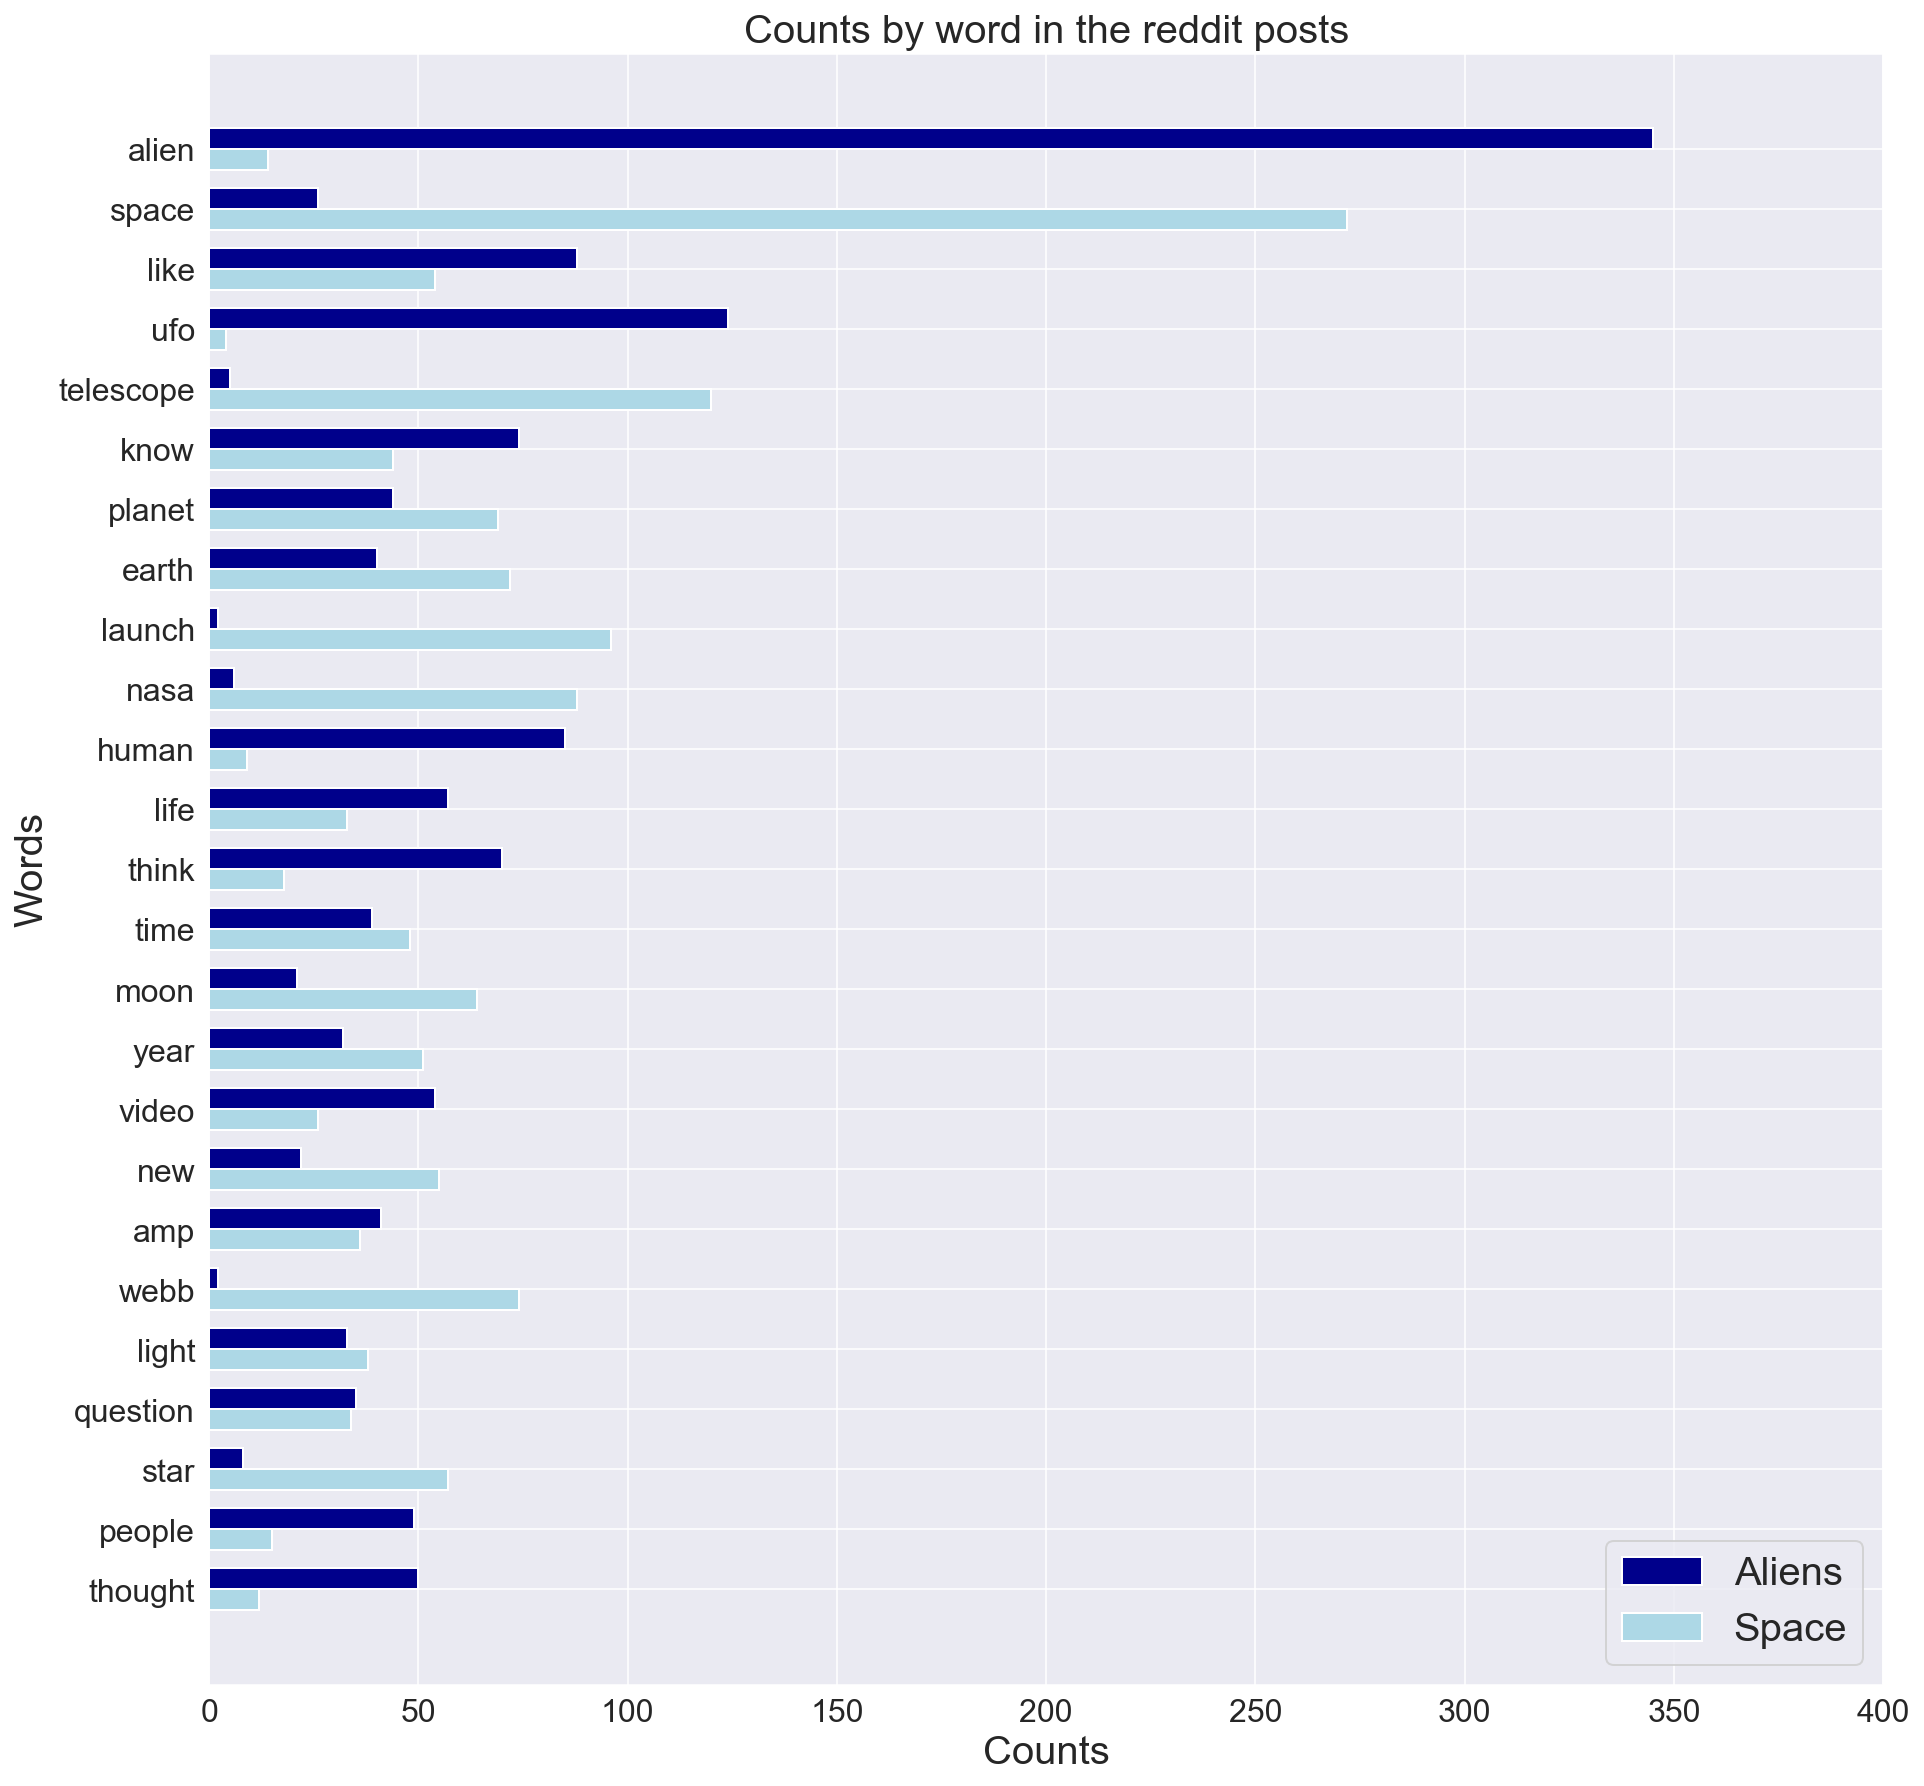

In [144]:
words_aliens = words
words_count_aliens = cv_train_small.loc[1]
words_space = words
words_count_space = cv_train_small.loc[0]

width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.barh(ind, words_count_aliens, width, color='darkblue')
rects2 = ax.barh(ind+width,words_count_space, width, color='lightblue')

# add some text for labels, title and axes ticks
ax.set_xlabel('Counts', fontsize=20)
ax.set_ylabel('Words', fontsize=20);

ax.set_title('Counts by word in the reddit posts', size=20)
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words) #,rotation='vertical'

ax.set_xlim(0,400)
ax.invert_yaxis()
ax.legend((rects1[0], rects2[0]), ('Aliens', 'Space'), fontsize=20)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# save image
plt.savefig('./images/word_reddit.png')

plt.show()

In [129]:
def show_wordcloud(data, title = None,file = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords.words(),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.25)

    plt.imshow(wordcloud)
    plt.show()
    fig.savefig('./images/word_cloud_'+file+'.png')

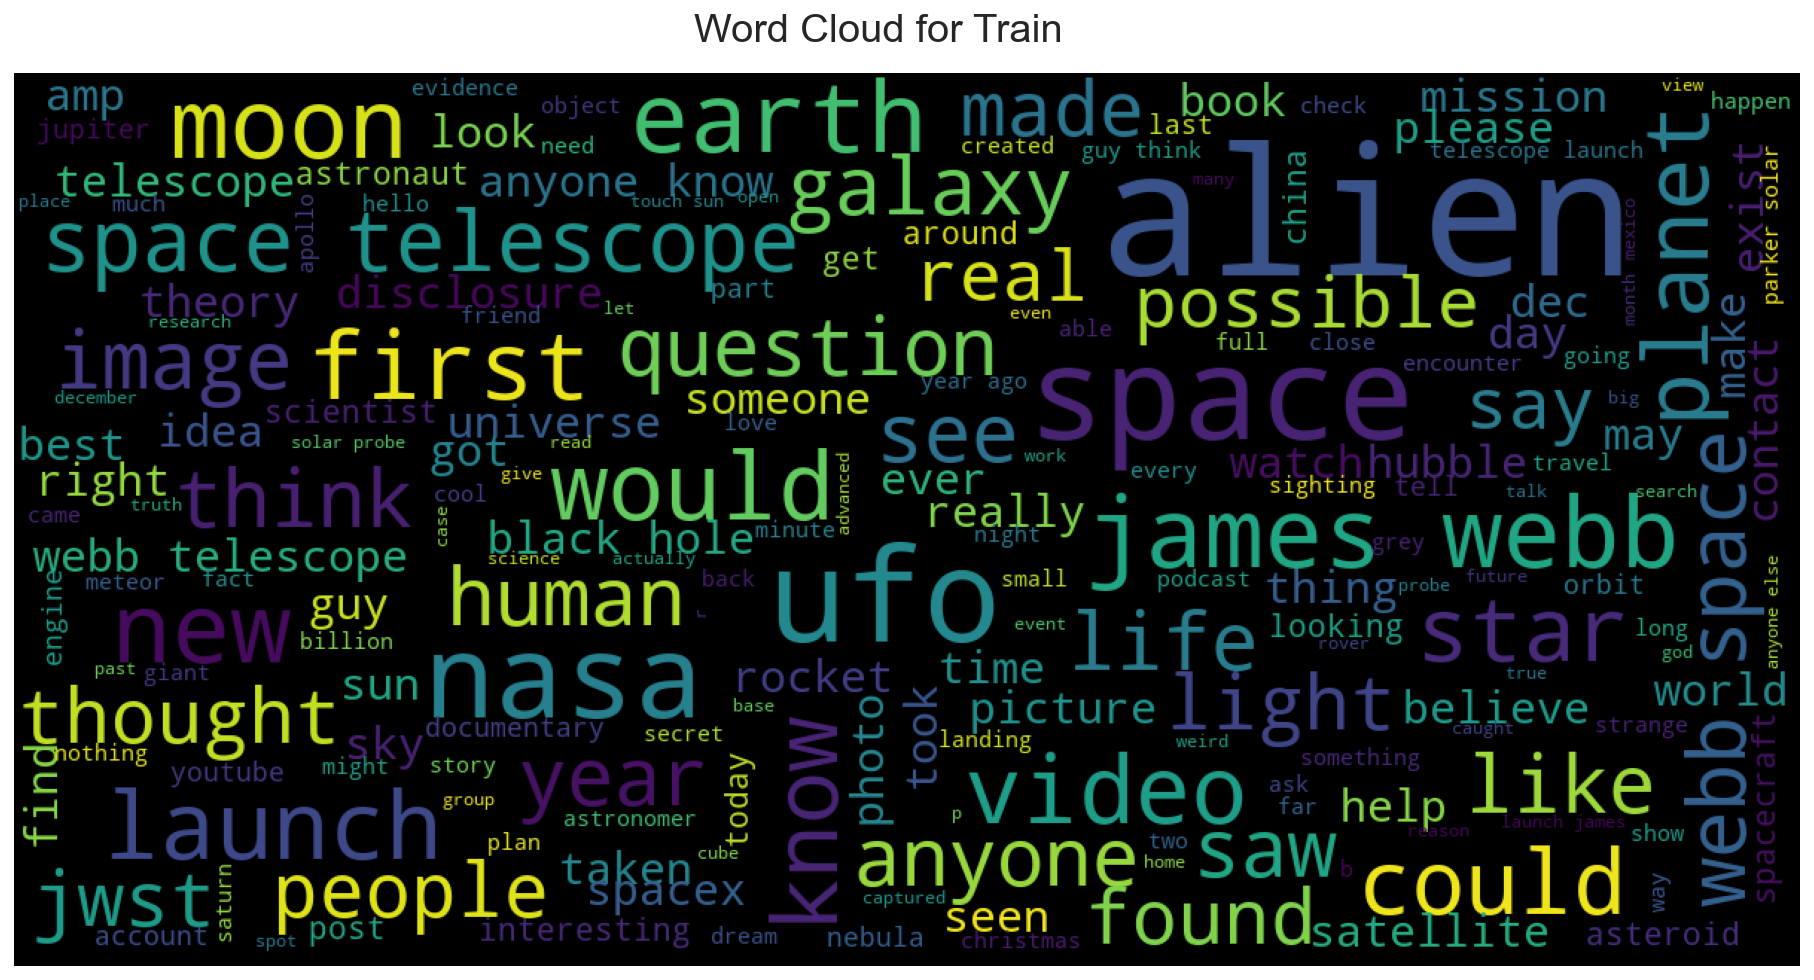

In [130]:
show_wordcloud(X_train,'Word Cloud for Train','train')

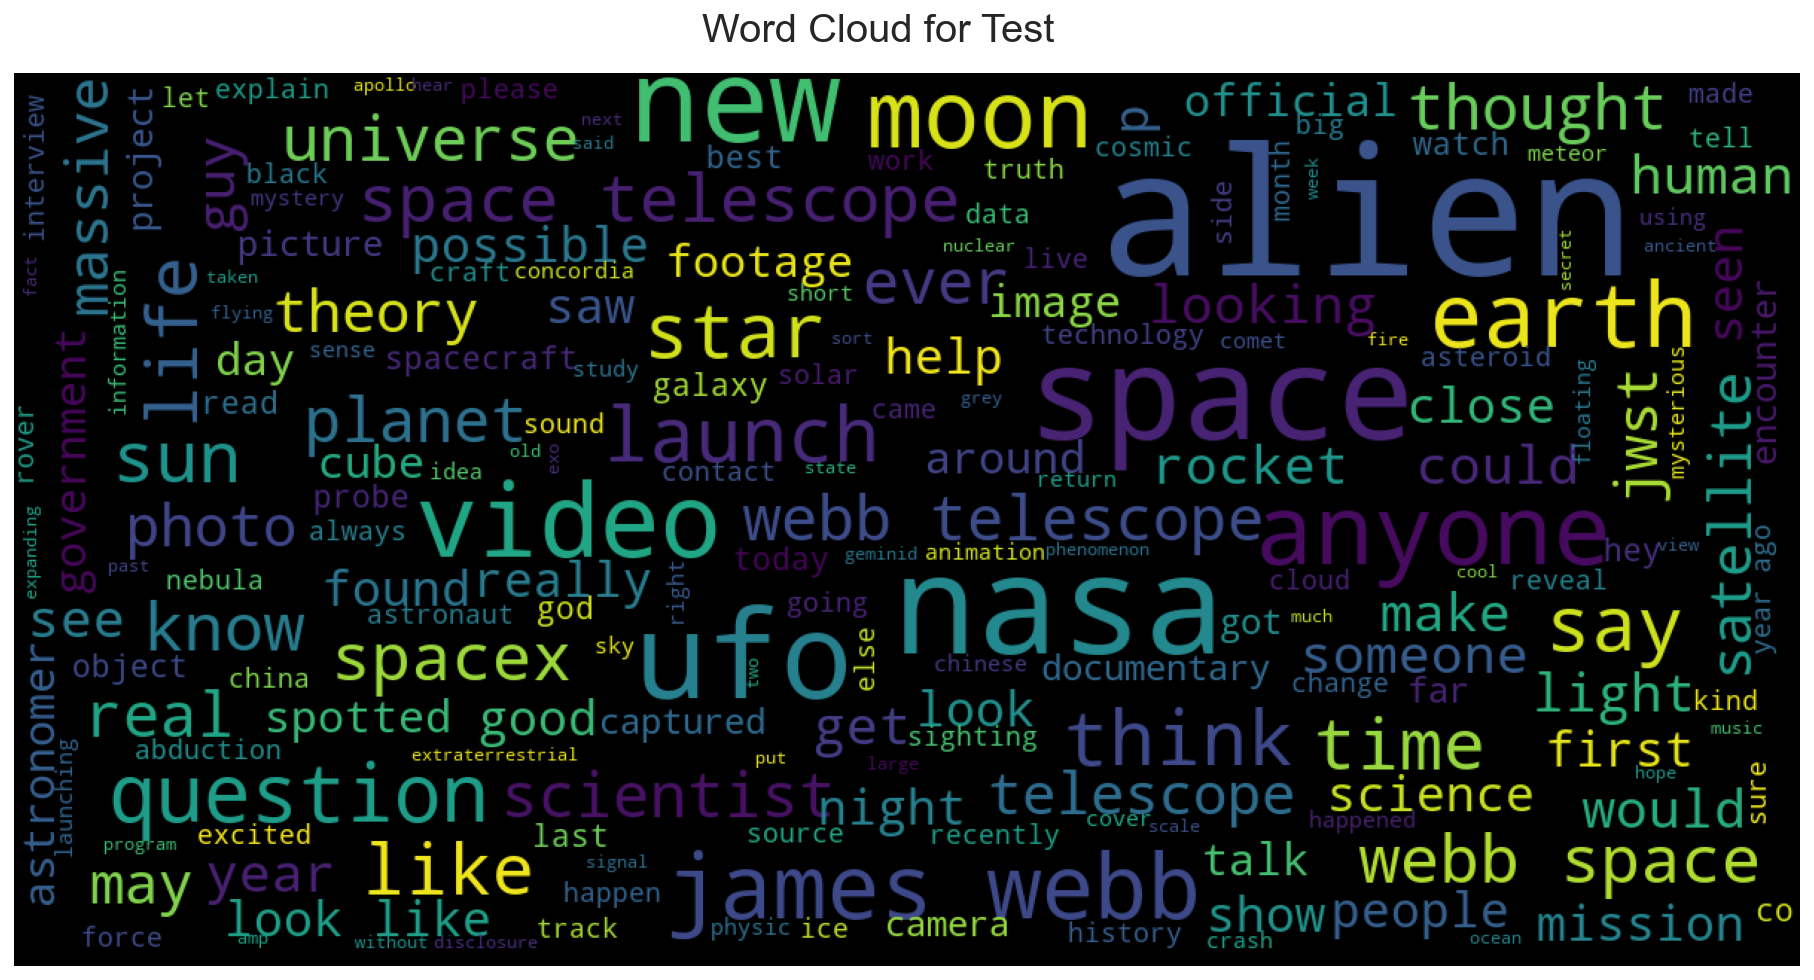

In [131]:
show_wordcloud(X_test,'Word Cloud for Test','test')

### Examine the Misses...

In [132]:
X_test_df = pd.DataFrame(X_test)

In [133]:
X_test_df.shape

(494, 1)

In [134]:
y_test.shape

(494,)

In [135]:
y_pred_lr_tv_test.shape

(494,)

In [136]:
# Adding the test values and the predicted values into the text for comparison
X_test_df['y'] = y_test.values
X_test_df['y_pred'] = y_pred_lr_tv_test

In [138]:
# There are 68 postings of incorrect classification
X_test_incorrect = X_test_df[X_test_df['y'] != X_test_df['y_pred']]
X_test_incorrect.head(68)

,text,y,y_pred
219,moon dance voice talk shit dimension face port...,0,1
1747,chinese rover yutu spotted cube shaped anomaly...,1,0
1809,opinion mystery image,1,0
1562,project commercial tribute television milton,1,0
1664,gary nolan spitting fire,1,0
2375,hey mod permanently ban account nuclearpastasalad,1,0
2142,next night ugh killthecameraman hovering looke...,1,0
2285,random thought human eventually leave earth li...,1,0
2301,possible disclosure james webb telescope launc...,1,0
474,nice video watch know get confidence speak smo...,0,1


### Observation on the misses

__Many of the incorrect predictions are due to the no meaning postings and also postings in the wrong subreddit. For example,__
1) kkkkkkkkkkk has no meaning on alien subreddit. 

2) alian was spelled wrongly so it is not correctly classified, one posting on alien word posted in space subreddit.

3) posting with strong correlation like aliens and space are both in the posting, 

In [139]:
# Show sample of correct classification
X_test_incorrect = X_test_df[X_test_df['y'] == X_test_df['y_pred']]
X_test_incorrect.head(50)

,text,y,y_pred
1852,tic tac brighton thermal video footage august,1,1
1294,big universe website made visualise size obser...,0,0
1269,nasa unveils new class astronaut candidate,0,0
40,using data several telescope worldwide team as...,0,0
2105,ufo video also still image look like humanoid ...,1,1
1286,happens wring wet towel floating space,0,0
641,canadian mda new leo satellite see needle hays...,0,0
2298,would screw alien seriously alien landed tomor...,1,1
34,happened spacex finally launching new starship...,0,0
681,sending labrador retriever puppy akiara play d...,0,0


Does the student explain how the model works and evaluate its performance successes/downfalls?

### __Observation on Test Set__

- The model has a high mean accuracy score (95.7% for training data) and (86.2% for test data)
- The mean accuracy score for training is higher than mean accuracy for test data. 
- The model has a consistent high accuracy of 86.2% test and 88.3% for val data.
- It also has a resonable precision (i.e the percent of my predictions were correct) score of 92% for aliens.
- The test set performed less than the validation set by 2.1%. It means that the results are consistent and good.
---

## Evaluation and Conceptual Understanding

## Logistic Regression with TF-IDF has the best accuracy for validation and test data. The results are also consistent through the modeling.

Success will be determine by the scoring on Text set.

In [145]:
t = PrettyTable(['Model', 'Baseline', 'Train', 'Validate', 'Test'])
t.add_row(['Logistic Regression with TF-IDF',
           '45%',
           '{:.1%}'.format(train_score_lr_tv), 
           '{:.1%}'.format(val_score_lr_tv), 
           '{:.1%}'.format(test_score_lr_tv)])
print(t)

+---------------------------------+----------+-------+----------+-------+
|              Model              | Baseline | Train | Validate |  Test |
+---------------------------------+----------+-------+----------+-------+
| Logistic Regression with TF-IDF |   45%    | 95.7% |  88.3%   | 86.2% |
+---------------------------------+----------+-------+----------+-------+


---

- Does the student accurately identify and explain the baseline score?

- Does the student select and use metrics relevant to the problem objective?

- Does the student interpret the results of their model for purposes of inference?

- Is domain knowledge demonstrated when interpreting results?

- Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?

### Justification for picking Logistic Regression TF-IDF & Interpretation of Model

The baseline score is based on the linear line of aliens and space postings and it is 45% chance of chosing alien as the posting.

1) TF-IDF penalize common words and give rare words more influence. This is relevant to our problem statement, space posts and aliens posts tends to use different terms. Space post might commonly use the word "launch", "jwst" because they are some of the most popular words associated with space. On the other hand, Aliens post might commonly find the word "UFO" commonly associated with aliens. Therefore, penalize common words and giving more influence to rare words would help us in our classification problem.

2) Comparing the model scores of CountVectorizer and TfidfVectorizer, in all instances models under TfidfVectorizer scores better except Random Forest. It could be because of its modeling technique of using strong predictors such as ufo to correlate. However, in the misses analysis, we also notice the word ufo appear in the space posting, this could be one of the reasons why Random Forest TF-IDF is lower.

3) Why Logistic Regression? Logistic Regression gives a high mean accuracy score for both Train data 95.7%, Vaidation data of 88.3% and Test data of 86.2%. This means that the model generalises well and scores well on unseen data. It returns high test score that are consistence with the Validation Score. In addition, it also scores much better than the baseline score of 45%

4) Logistic Regression allows me to interpret model coefficients as indicators of feature importance. For example, the presence of the word "ufo" increases by 1, the post is about 488 times as likely to be a aliens post. Likewise for the word 'ufo' where it is 42 times. It is logical to think of ufo word when aliens comes to mind. It almost always comes in pair. 

5) Based on reading the posts in reddit, aliens fans heavily discussed in ufo related incidents such as involving human, believe, disclosure and think. Aliens fans always include their own views to any incidents as aliens is not offically factual and they would like to speculate.

6) On the other hand, words such as space, nasa, launch, moon, jswt all are considered rare words and indicates the post is from space instead of aliens.

7) The interpretation of coefficients allows us to make useful recommendations for our problem statement and allow us to target specific marketing for our client.

8) Logistic Regression however has its own limitation. It assumes independence of independent Variables and the independent variables X1...Xm are linearly related to the logit of the probability but not always the case. Nevertheless, it proves to be a good model to use.

---

## Conclusions and Recommendations

- Does the student provide appropriate context to connect individual steps back to the overall project?

This project first started by scrapping unique posts from reddit and the 2 topics we explored is 'Aliens' and "Space'. The data was first scrapped to ensure we are doing it correcttly and therefore looping for 1500 posts per subreddit. In total, 3000 posts werer collected. It is then inspected and cleaned for analysis. Histogram for the subreddits was examined on their distribution. In exploratory data analysis (EDA), we compared the general behavioural and relationships (text length, upvote_ratio, num_comments and score) of aliens fans and space fans and also removing outliners using IQR model. Word Cloud used to common words. Next, models were build to make predictions on unseen data. Logistic regression was identified as the most appropriate model, its coefficients were interpreted. For example, the exp coefficients if the top key words increased by 1. Meaningful recommendations were given based on EDA and model. Therefore, each individual step connects to the overall project.

---

- Is it clear how the final recommendations were reached?
- Are the conclusions/recommendations clearly stated?
- Does the conclusion answer the original problem statement?
- Does the student address how findings of this research can be applied for the benefit of stakeholders?

Our research team had successfully answered the original problem statement, which is to find the key words that best differentiate aliens fans from space fans in reddit posts. We have also use these key words to derive marketing strategies below.


__Marketing Strategies__

1) Search Engine Optimisation (SEO)
- Based on our research through reddit post and our logistic model, keys words such as Alien, UFO, human guy, think, believe, disclosure, thought and strange are the words that best indicate a alien post. This means that, aliens fanatics and hard-core fans use such words when talking ahout aliens topics in the discussions. In essence, MIB can include these words during their web improvement process to boost online presence and improves search engine optimisation (SEO).

2) Keep the Marketing Message precise and appealing
- Based on our research, aliens posts (mean of 162 text length) are generally longer than space posts (mean 125 text length). There should have some specific contents that get alot more response than the standard distibution text length. Higher distribution are at 40-60 Aliens postings have consistent score regardless of text length as long as the contect is meaningful. Social media platforms would be a good channel for MIB's markeing effort. For example Twitter. A meaningful and appealing twit can start a long message of communications.

3) Marketing Message Needs to be Meaningful
- Research result on the number of comments showed that the scoring are more spread out. As long as the content is meaningful, aliens fans will continue to discuss and participate in the discussions. In addition, the number of comments in aliens posts are much longer than space post. This means that there are still alot of core aliens fans to keep the discussion going.

- MIB can use the key words identified in our model to create meaningful discussion topics. For example, a discussion on human abduction by aliens. Besides that, we also discovered they like to include their own opinions and views with word such as believe, think from the word cloud. MIB should look for past information and resurfaced the discussion and if there is any new findings. That will surely arouse their interest again.

In summary, MIB can use the recommendations above to better market and so as to win back more fans. This important to ensure aliens fans does not continue to dwindle. Once we built up the fan base, MIB can then organise events, activities and maybe membership to ensure it has more funding and sponsorship such as ticket sales and merchandise. Secondary stakeholders such as aliens associations will also benefit in terms of their club membership, events, shows, podcasts and awareness to the public.

---

__What is the next step moving forward?__
- Are future steps to move the project forward identified?

### Expansion work on our project

- A larger dataset will be used to further improve the accuracy. In the future, a larger dataset could be gathered. After EDA cleaning, there are about 1122 aliens posts and 1347 for space. Exploring a larger dataset and different posts dates will help us to better analysis.

- More models could be explored, such as catboost, KNN, topic classification and so on. We should continue to look out for new models for better prediction. May be neural networks can be looked into as well.

- From the stakeholders benefits, they now have a better understanding of the words weightage through word cloud. Future research can combine both qualitative and quantitative methods. Our data science research can be supported by interviews or focus groups. This would allow us to discover more meaning behind our findings. For example, we can invite reputable alien fans to discuss on the keys and its mode. This would help us derive meaning from the fans perspective.

- Our model is limited to the corpus of texts obtained from scrapping aliens and space reddit APIs such as pushshift or PRAW. It would be better if the model can learn on its own, constantly update new text. This would allow the model to stay relevant longer.

- We plan to incorporate image analysis, sentiment analysis, and topic modelling as follows:

1) Image analysis is to increase our scope because we understand that a lot of posts have included images but now we are only analysing text. 

2) Sentiment analysis can help to gauge whether people are generally feeling positive or negative towards the aliens. Perhaps when the positivity towards aliens has reached certain level, MIB may disclose what they know about aliens. 

3) Topic modelling can identify more specifically the topic of each post. MIB will be able to monitor the focus of aliens discussion that may change over time, or may change based on new leaked information. MIB can divert people’s attention by creating news related to these topic on social media, events and podcasts